Evaluation of assignment problem

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import defaultdict
import time

import utils
import networks
import importlib
# importlib.reload(utils)
# importlib.reload(networks.scoring_v1)
# importlib.reload(networks.scoring_demo)
# importlib.reload(networks.encoders)

from utils import *
from objects.point import Point, get_random_point
from objects.utils import distance
from objects.gamble_triple import GambleTriple, random_triple
from networks.model_trainer import ModelTrainer
from dispatch.solvers import HungarianSolver
from networks.scoring_v1 import ScoringNet
# from networks.scoring_demo import ScoringNetDemo
from networks.points_distance_net import PointDistNet
from networks.encoders import PointEncoder
from dispatch.scorings import ETAScoring
from dispatch.dispatch import Dispatch
from simulator.base_simulator import BaseSimulator
from IPython.display import clear_output
from matplotlib.pyplot import figure

In [6]:
bounds = (Point(0, 0), Point(10, 10))
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

point_encoder = PointEncoder(64, device=device)
point_encoder_path = 'pretained_models/point_encoder64/point_encoder64.pt'
point_encoder.load_state_dict(torch.load(point_encoder_path, map_location=device))

net = ScoringNet(
    mode='default',
    point_encoder=point_encoder,
    n_layers=2,
    d_model=512,
    n_head=4,
    dim_ff=512,
    point_enc_dim=32,
    number_enc_dim=8,
    device=device
)

net_path = 'pretained_models/assignment_cloning_model_v2/model.pt'
net.load_state_dict(torch.load(net_path, map_location=device))
net.eval();

Evaluation of accuracy by gambles

In [18]:
def target_assigments(triple):
    scoring = ETAScoring()
    solver = HungarianSolver()

    scores = scoring(triple.orders, triple.couriers)
    ords, crrs = solver(scores)
    answer = -np.ones(len(triple.orders))
    for o, c in zip(ords, crrs):
        answer[o] = c
    return answer

def pred_assigments(triple):
    preds = net([triple], 0)
    fake_courier_idx = preds[0].shape[1] - 1
    argmaxes = torch.argmax(preds[0], dim=-1)
    return torch.where(argmaxes == fake_courier_idx, -1, argmaxes).numpy()

def target_assigments_batch(triples):
    assignments_batch = []
    for triple in triples:
        assignments_batch.append(target_assigments(triple))
    
    return assignments_batch

def pred_assigments_batch(triples):
    preds = net(triples, 0)
    fake_courier_idx = preds.shape[2] - 1
    argmaxes = torch.argmax(preds, dim=-1)
    assignments_batch_tens = torch.where(argmaxes == fake_courier_idx, -1, argmaxes).numpy()

    assignments_batch = []
    for i, assignments_tens in enumerate(assignments_batch_tens):
        num_orders = len(triples[i].orders)
        assignments_batch.append(assignments_tens[:num_orders])

    return assignments_batch

In [19]:
triples = [random_triple(bounds, max_items=3, same_number=True) for _ in range(2)]

print(target_assigments_batch(triples))
print(pred_assigments_batch(triples))

[array([0., 1., 2.]), array([0.])]
[array([0, 1, 2], dtype=int64), array([0], dtype=int64)]


In [29]:
from collections import Counter

def get_dict_metrics(a, b, n_couriers = 1000):
    return {
        'fake_mistake_not_assigns': ((a != b) & (a == -1) & (b < n_couriers)).sum(),
        'fake_mistake_assigns': ((a != b) & (b == -1)).sum(),
        'real_mistakes': ((a != b) & (a != -1) & (b != -1) & (b < n_couriers)).sum(),
        'masked_assigns': ((b >= n_couriers)).sum(),
        'correct': (a == b).sum(),
    }

def get_metrics(n_samples, max_items=3):
    c = Counter()
    for _ in range(n_samples):
        triple = random_triple(bounds, max_items=max_items)
        pred_ass = pred_assigments(triple)
        tgt_ass = target_assigments(triple)
        assert pred_ass.shape == tgt_ass.shape
        c.update(get_dict_metrics(tgt_ass, pred_ass))
    
    return c

def get_metrics_batch(batch_size, n_samples, max_items=3):
    c = Counter()
    for _ in range(n_samples):
        triples = [random_triple(bounds, max_items=max_items) for _ in range(batch_size)]
        pred_ass_batch = pred_assigments_batch(triples)
        tgt_ass_batch = target_assigments_batch(triples)
        assert len(pred_ass_batch) == len(tgt_ass_batch)
        for i, (pred_ass, tgt_ass) in enumerate(zip(pred_ass_batch, tgt_ass_batch)):
            assert pred_ass.shape == tgt_ass.shape
            c.update(get_dict_metrics(tgt_ass, pred_ass, n_couriers=len(triples[i].couriers)))
    
    return c

Without masks (wo batches)

In [7]:
metrics = get_metrics(n_samples=100, max_items=10)
metrics

Counter({'fake_mistake_not_assigns': 24,
         'fake_mistake_assigns': 17,
         'real_mistakes': 51,
         'correct': 442})

In [8]:
num_total_orders = sum(metrics.values())
for k, v in metrics.items():
    print(k + ': ', v / num_total_orders)

fake_mistake_not_assigns:  0.0449438202247191
fake_mistake_assigns:  0.031835205992509365
real_mistakes:  0.09550561797752809
correct:  0.8277153558052435


Аккураси модели 85%
10% теряется на неверных назначениях курьеров реальных
5% на назначениях фейковых

Ситуация резко ухудшается при большем кол-во итемов (чем то, на чем модель училась). Но в рамках того, чему модель училась, все норм

Ниже: accuracy в зависимости от max_items

Модель как будто поняла, что не надо назначать на маскированных челов

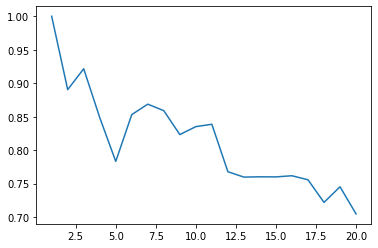

In [87]:
accuracies = [None]
for n_items in range(1, 21):
    metrics = get_metrics(n_samples=50, max_items=n_items)
    num_total_orders = sum(metrics.values())
    accuracies.append(metrics['correct'] / num_total_orders)

plt.plot(accuracies)

With masks (and batches)

In [31]:
metrics = get_metrics_batch(batch_size=10, n_samples=20, max_items=10)
print(metrics)

num_total_orders = sum(metrics.values())
for k, v in metrics.items():
    print(k + ': ', v / num_total_orders)

Counter({'correct': 888, 'real_mistakes': 144, 'fake_mistake_assigns': 32, 'fake_mistake_not_assigns': 27, 'masked_assigns': 5})
fake_mistake_not_assigns:  0.024635036496350366
fake_mistake_assigns:  0.029197080291970802
real_mistakes:  0.13138686131386862
masked_assigns:  0.004562043795620438
correct:  0.8102189781021898


Evaluation of CR

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from dispatch.dispatch import Dispatch, NeuralDispatch
from simulator.base_simulator import BaseSimulator

Default dispatch

In [2]:
dsp = Dispatch()
sim = BaseSimulator(dsp)

all_metrics = []
for i in range(1000):
    metrics = sim.GetMetrics()
    all_metrics.append(metrics)
    sim.Next()


CR:  0.6623292586136372


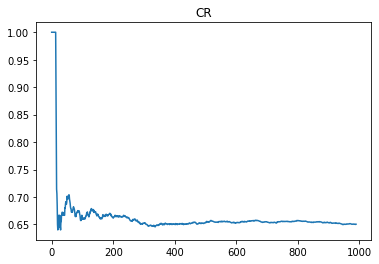

current free couriers:  0.112
current free orders:  12.717
current active routes:  19.888


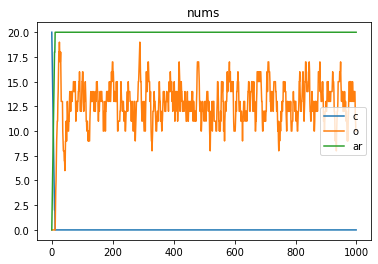

In [3]:
def print_metrics(all_metrics):
    plt.title('CR')
    plt.plot([m['completed_orders'] / m['finished_orders'] for m in all_metrics if m['finished_orders'] != 0])
    print('CR: ', np.mean([m['completed_orders'] / m['finished_orders'] for m in all_metrics if m['finished_orders'] != 0]))
    plt.show()
    plt.title('nums')
    plt.plot([m['current_free_couriers'] for m in all_metrics], label='c')
    plt.plot([m['current_free_orders'] for m in all_metrics], label='o')
    plt.plot([m['current_active_routes'] for m in all_metrics], label='ar')
    plt.legend()
    print('current free couriers: ', np.mean([m['current_free_couriers'] for m in all_metrics]))
    print('current free orders: ', np.mean([m['current_free_orders'] for m in all_metrics]))
    print('current active routes: ', np.mean([m['current_active_routes'] for m in all_metrics]))

print_metrics(all_metrics)

In [4]:
sim.GetMetrics()

{'iter': 1000,
 'completed_orders': 1281,
 'finished_orders': 1970,
 'current_free_couriers': 0,
 'current_free_orders': 10,
 'current_active_routes': 20,
 'total_eta': 1.9930485193855516}

Neural dispatch

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from dispatch.dispatch import Dispatch, NeuralDispatch
from simulator.base_simulator import BaseSimulator
from tqdm import tqdm

dsp = NeuralDispatch(net)
sim = BaseSimulator(dsp)

all_metrics = []
for i in tqdm(range(500)):
    metrics = sim.GetMetrics()
    all_metrics.append(metrics)
    sim.Next()


100%|██████████| 500/500 [00:32<00:00, 15.57it/s]


CR:  0.5292722359989297


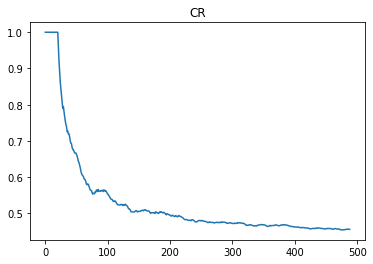

current free couriers:  0.816
current free orders:  20.83
current active routes:  19.184


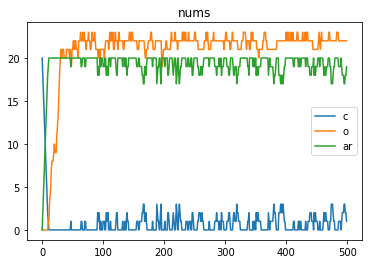

In [12]:
def print_metrics(all_metrics):
    plt.title('CR')
    plt.plot([m['completed_orders'] / m['finished_orders'] for m in all_metrics if m['finished_orders'] != 0])
    print('CR: ', np.mean([m['completed_orders'] / m['finished_orders'] for m in all_metrics if m['finished_orders'] != 0]))
    plt.show()
    plt.title('nums')
    plt.plot([m['current_free_couriers'] for m in all_metrics], label='c')
    plt.plot([m['current_free_orders'] for m in all_metrics], label='o')
    plt.plot([m['current_active_routes'] for m in all_metrics], label='ar')
    plt.legend()
    print('current free couriers: ', np.mean([m['current_free_couriers'] for m in all_metrics]))
    print('current free orders: ', np.mean([m['current_free_orders'] for m in all_metrics]))
    print('current active routes: ', np.mean([m['current_active_routes'] for m in all_metrics]))

print_metrics(all_metrics)

In [13]:
sim.GetMetrics()

{'iter': 500,
 'completed_orders': 436,
 'finished_orders': 958,
 'current_free_couriers': 0,
 'current_free_orders': 22,
 'current_active_routes': 20,
 'total_eta': 10.109865439257533}

Default dispatch's CR is 65% which is better than Neural dispatch 50%